In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
import xgboost as xgb
from xgboost import plot_importance
import warnings

import time
import datetime
warnings.filterwarnings('ignore')
path = "D:/program/program1/Cargo_forecast/dot_data_all/"

In [2]:
dot_res = pd.read_csv(path + "dot_res.csv", encoding = 'GBK', index_col = 0)

In [71]:
dot_res = dot_res[~dot_res['dot'].isin(a1)]

In [72]:
dot_res.isnull().sum()

dot            0
city_code      0
order_date     0
order_num      0
dot_id         0
year           0
month          0
day            0
dayofweek      0
dayofyear      0
weekofyear     0
weekofsun      0
holidays       0
lagging1       0
lagging2       0
lagging3       0
lagging4       0
lagging5       0
lagging6       0
lagging7       0
rolling3       0
rolling5       0
rolling7       0
week_mean      0
week_median    0
week_min       0
week_max       0
week_std       0
day_mean       0
day_median     0
              ..
华北             0
华南             0
上海             0
云南省            0
内蒙古            0
北京             0
吉林省            0
四川省            0
天津             0
安徽省            0
山东省            0
山西省            0
广东省            0
广西             0
新疆             0
江苏省            0
江西省            0
河北省            0
河南省            0
浙江省            0
海南省            0
湖北省            0
湖南省            0
甘肃省            0
福建省            0
贵州省            0
辽宁省            0
重庆            

In [64]:
a1 = dot_res[dot_res['week_std'].isnull()]['dot'].unique()

In [ ]:
dot_res[]

In [3]:
dot_res['order_date'] = pd.to_datetime(dot_res['order_date'])

In [4]:
len(dot_res['dot'].unique())

2407

In [16]:
# dot_train = dot_res[: -(30 * 2407)]
# dot_test = dot_res[-(30 * 2407) :]

In [7]:
train_date = dot_res['order_date'].max() + pd.DateOffset(months = -1)
dot_train = dot_res[dot_res['order_date'] <= train_date]
dot_test = dot_res[dot_res['order_date'] > train_date]

In [8]:
dot_xtrain = dot_train.drop(['order_num'], axis = 1)
dot_ytrain = dot_train['order_num']
dot_xtest = dot_test.drop(['order_num'], axis = 1)
dot_ytest = dot_test['order_num']

In [9]:
def RMSE(y_test, y_pred):
    return np.sqrt(np.sum((y_test - y_pred) ** 2)/len(y_test))

def MAE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

In [10]:
def xgboost_model(x_train, y_train):
    params = {
        "learning_rate": 0.01,
        "n_estimators": 3300,
        "max_depth": 5,
        "min_child_weight": 3,
        "gamma": 0.5,
        "subsample": 0.9,
        "colsample_bytree": 0.8,
        "silent": 1,
        "reg_alpha" : 0.05,
        "reg_lambda" : 0.05,
        "seed": 21
    }
    print("train_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    gbm = xgb.XGBRegressor(**params)
    gbm.fit(x_train.drop(['dot', 'order_date'], axis = 1), y_train)
    print("train_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    for column, importance in zip(x_train.drop(['dot', 'order_date'], axis = 1).columns, gbm.feature_importances_):
        print(column, '\t', importance)
    # plot_importance(gbm)
    # plt.savefig(path + "feature_importance.png")
    
    return gbm

In [11]:
gbm = xgboost_model(dot_xtrain, dot_ytrain)

train_start :  2019-02-26 09:56:23
train_end :  2019-02-26 11:45:06
city_code 	 0.0138158975
dot_id 	 0.021206273
year 	 0.008396288
month 	 0.010459435
day 	 0.034775827
dayofweek 	 0.04830432
dayofyear 	 0.058886927
weekofyear 	 0.015211858
weekofsun 	 0.0058507146
holidays 	 0.037844885
lagging1 	 0.058948513
lagging2 	 0.024460092
lagging3 	 0.022201922
lagging4 	 0.019307358
lagging5 	 0.018096156
lagging6 	 0.020241419
lagging7 	 0.045912713
rolling3 	 0.026112663
rolling5 	 0.021534735
rolling7 	 0.041519545
week_mean 	 0.046107735
week_median 	 0.03871736
week_min 	 0.009720397
week_max 	 0.026010018
week_std 	 0.059153803
day_mean 	 0.04225858
day_median 	 0.04339793
day_min 	 0.04011332
day_max 	 0.050336674
day_std 	 0.07495073
二级中转场 	 0.0
大点部 	 0.00041057644
小点部 	 0.00013343735
航空组 	 0.0003695188
虚拟点部 	 0.0
京津冀 	 0.0007390376
华东 	 0.00045163409
华北 	 0.0012419937
华南 	 0.0014370176
上海 	 0.0005542782
云南省 	 0.00029766792
内蒙古 	 0.0
北京 	 0.0004413697
吉林省 	 6.158647e-05
四川省 	 0.00

### dump model

import pickle 
fw = open(path + "gbm.txt", 'wb') 
pickle.dump(gbm, fw)

### load model

import pickle rw = open(path + 'gbm.txt', 'rb') gbm = pickle.load(rw)

### 预测方式1

In [14]:
def xgb_predict(gbm, x_test, y_test, path):
    # 验证
    print("predict_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    print("predict_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : np.expm1(y_test), 'y_pre' : np.expm1(y_pre)})
    result['RMSE'] = RMSE(np.expm1(y_test), np.expm1(y_pre))
    result['MAE'] = MAE(np.expm1(y_test), np.expm1(y_pre))
    print("MAE : ", MAE(np.expm1(y_test), np.expm1(y_pre)), " RMSE : ", RMSE(np.expm1(y_test), np.expm1(y_pre)))
#     result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : y_test, 'y_pre' : y_pre})
#     result['RMSE'] = RMSE(y_test, y_pre)
#     result['MAE'] = MAE(y_test, y_pre)
#     print("MAE : ", MAE(y_test, y_pre), " RMSE : ", RMSE(y_test, y_pre))
    
    result.to_csv(path + "dot_result.csv", encoding = 'GBK', index = False)
    return result

In [15]:
result = xgb_predict(gbm, dot_xtest, dot_ytest, path)

predict_start :  2019-02-26 11:49:43
predict_end :  2019-02-26 11:49:53
MAE :  8.28976449331314  RMSE :  13.809427900237647


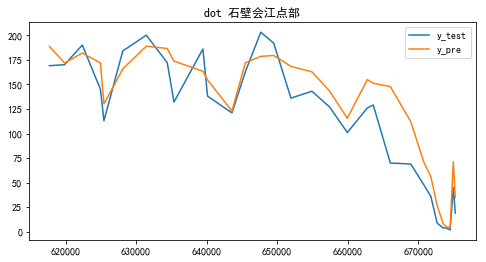

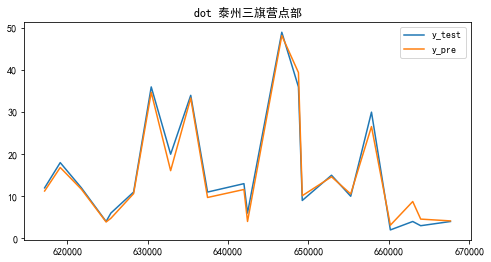

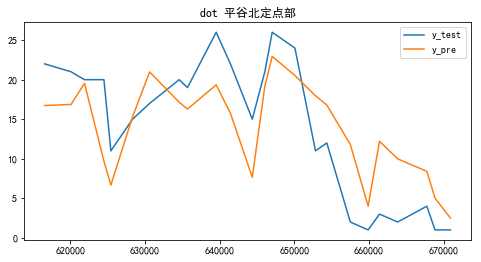

In [19]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_test','y_pre']
L = np.random.randint( low = 0, high = 2411, size = 3 )
for i in L:
    s1 = pd.DataFrame(result[result['dot'] == result['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(result['dot'].reset_index(drop = True).unique()[i]), figsize = (8,4))

### 预测方式2

In [21]:
def pre_feature(data, dot_name):
    x_test_tmp = pd.DataFrame()
    rolling_tmp = pd.DataFrame()
    for dot in dot_name:
        # lagging
        dot_test = data.loc[data['dot'] == dot]
        dot_test_ts = dot_test.copy()
        dot_test['lagging7'] = dot_test['lagging6']
        dot_test['lagging6'] = dot_test['lagging5']
        dot_test['lagging5'] = dot_test['lagging4']
        dot_test['lagging4'] = dot_test['lagging3']
        dot_test['lagging3'] = dot_test['lagging2']
        dot_test['lagging2'] = dot_test['lagging1']
        dot_test['lagging1'] = dot_test['order_num']

        x_test_tmp = pd.concat([x_test_tmp, dot_test])

        # rolling
        dot_test_ts.index = pd.to_datetime(dot_test_ts['order_date'])
        num_ts = dot_test_ts.loc[dot_test_ts['dot'] == dot, ['order_num']]
        rolling = pd.concat([num_ts.rolling(window = 3).mean(), num_ts.rolling(window = 5).mean(), num_ts.rolling(window = 7).mean()], axis = 1)
    #     rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling_tmp = pd.concat([rolling_tmp, rolling])

    x_test = pd.merge(x_test_tmp.drop(['rolling3', 'rolling5', 'rolling7'], axis = 1), rolling_tmp, how = 'left', on = ['dot', 'order_date'])
    x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = 1)
    x_test.dropna(axis = 0, inplace = True)
    
    return x_test

In [ ]:
print("START : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
result_to_csv = pd.DataFrame()
pre_date = dot_train['order_date'].max() + pd.DateOffset(months = -1)
org_test = dot_train[dot_train['order_date'] > pre_date]
feature = ['dot', 'city_code', 'order_date', 'dot_id', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', 'week_mean',
       'week_median', 'week_min', 'week_max', 'week_std', 'day_mean',
       'day_median', 'day_min', 'day_max', 'day_std', '二级中转场', '大点部', '小点部',
       '航空组', '虚拟点部', '京津冀', '华东', '华北', '华南', '上海', '云南省', '内蒙古', '北京', '吉林省',
       '四川省', '天津', '安徽省', '山东省', '山西省', '广东省', '广西', '新疆', '江苏省', '江西省',
       '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省', '甘肃省', '福建省', '贵州省', '辽宁省',
       '重庆', '陕西省', '黑龙江省']
feature_num = ['dot', 'city_code', 'order_date', 'dot_id', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', 'week_mean',
       'week_median', 'week_min', 'week_max', 'week_std', 'day_mean',
       'day_median', 'day_min', 'day_max', 'day_std', '二级中转场', '大点部', '小点部',
       '航空组', '虚拟点部', '京津冀', '华东', '华北', '华南', '上海', '云南省', '内蒙古', '北京', '吉林省',
       '四川省', '天津', '安徽省', '山东省', '山西省', '广东省', '广西', '新疆', '江苏省', '江西省',
       '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省', '甘肃省', '福建省', '贵州省', '辽宁省',
       '重庆', '陕西省', '黑龙江省']
feature_date = ['dot', 'city_code', 'order_date', 'order_num', 'dot_id', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', 'week_mean',
       'week_median', 'week_min', 'week_max', 'week_std', 'day_mean',
       'day_median', 'day_min', 'day_max', 'day_std', '二级中转场', '大点部', '小点部',
       '航空组', '虚拟点部', '京津冀', '华东', '华北', '华南', '上海', '云南省', '内蒙古', '北京', '吉林省',
       '四川省', '天津', '安徽省', '山东省', '山西省', '广东省', '广西', '新疆', '江苏省', '江西省',
       '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省', '甘肃省', '福建省', '贵州省', '辽宁省',
       '重庆', '陕西省', '黑龙江省']
for i in range(15):
    print(i)
    x_test = pre_feature(org_test, all_dot)
    last_train_date = pd.to_datetime('2019-01-08') + pd.DateOffset(days = i + 1)
    x_test = x_test.loc[x_test['order_date'] == last_train_date, feature]#.drop(['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun', 'holidays'])
#     x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = i)
    
    x_test = time_feature(x_test)
    x_test = x_test[feature_num]

    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'order_num' : y_pre})
    result_to_csv = pd.concat([result_to_csv, result])
    x_test = pd.merge(x_test, result, on = ['dot', 'order_date'], how = 'left')
    x_test = x_test[feature_date]
    
    org_test = pd.concat([org_test, x_test])
print("END : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [ ]:
result_to_csv['order_num'] = np.expm1(result_to_csv['order_num'])
result_to_csv.head()

In [ ]:
org_data = dot_data.copy()
org_data['order_num'] = np.expm1(org_data['order_num'])
org_data.tail()

In [ ]:
r1 = pd.merge(result_to_csv, org_data, on = ['dot', 'order_date'], how = 'left')
r1 = r1[['dot', 'order_date', 'order_num_x', 'dot_id', 'order_num_y']]
r1.columns = ['dot', 'order_date', 'y_pre', 'dot_id', 'y_test']
r1 = r1[['dot', 'order_date', 'dot_id', 'y_test', 'y_pre']]
r1.head()

In [ ]:
print("MAE : ", MAE(r1.y_test, r1.y_pre))
print("RMSE : ", RMSE(r1.y_test, r1.y_pre))

In [ ]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_pre','y_test']
L = np.random.randint( low = 0, high = 183, size = 3 )
for i in L:
    s1 = pd.DataFrame(r1[r1['dot'] == r1['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(r1['dot'].unique()[i]), figsize = (8,4))

In [86]:
dot_train.columns.drop(['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun', 'holidays'])

Index(['dot', 'city_code', 'order_date', 'order_num', 'dot_id', 'lagging1',
       'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7',
       'rolling3', 'rolling5', 'rolling7', 'week_mean', 'week_median',
       'week_min', 'week_max', 'week_std', 'day_mean', 'day_median', 'day_min',
       'day_max', 'day_std', '二级中转场', '大点部', '小点部', '航空组', '虚拟点部', '京津冀', '华东',
       '华北', '华南', '上海', '云南省', '内蒙古', '北京', '吉林省', '四川省', '天津', '安徽省', '山东省',
       '山西省', '广东省', '广西', '新疆', '江苏省', '江西省', '河北省', '河南省', '浙江省', '海南省',
       '湖北省', '湖南省', '甘肃省', '福建省', '贵州省', '辽宁省', '重庆', '陕西省', '黑龙江省'],
      dtype='object')

In [90]:
pd.date_range('2017-01-01', '2019-02-08', freq='W-SUN')

DatetimeIndex(['2017-01-01', '2017-01-08', '2017-01-15', '2017-01-22',
               '2017-01-29', '2017-02-05', '2017-02-12', '2017-02-19',
               '2017-02-26', '2017-03-05',
               ...
               '2018-12-02', '2018-12-09', '2018-12-16', '2018-12-23',
               '2018-12-30', '2019-01-06', '2019-01-13', '2019-01-20',
               '2019-01-27', '2019-02-03'],
              dtype='datetime64[ns]', length=110, freq='W-SUN')